In [1]:
!nvidia-smi

Wed Sep 10 19:32:30 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.247.01             Driver Version: 535.247.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX 4000 Ada Gene...    Off | 00000000:01:00.0 Off |                  Off |
| 30%   29C    P8              13W / 130W |     28MiB / 20475MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import sys

print(sys.version)

3.12.2 | packaged by Anaconda, Inc. | (main, Feb 27 2024, 17:35:02) [GCC 11.2.0]


In [3]:
print(sys.executable)

/courses/TDDE70/miniconda3/envs/tdde70/bin/python


In [ ]:
!pip list

In [6]:
!pip install -q "inference-gpu>=0.9.14" "supervision>=0.23.0" "umap-learn>=0.5.5" "scikit-learn>=1.3.0" opencv-python-headless tqdm

In [ ]:
!pip install numpy==1.26.4

In [ ]:
pip install 'inference[transformers,yolo-world]'

## Load finetuned models

In [1]:
import os
from ultralytics import YOLO

os.environ["ONNXRUNTIME_EXECUTION_PROVIDERS"] = "[CUDAExecutionProvider]"

yolo_finetuned_1280 = YOLO("models/yolo_finetuned_1280imgs_5batch/best.pt")
yolo_finetuned_640 = YOLO("models/yolo_finetuned_640imgs_20batch/best.pt")

## Ball, player, goalkeeper and referee detection

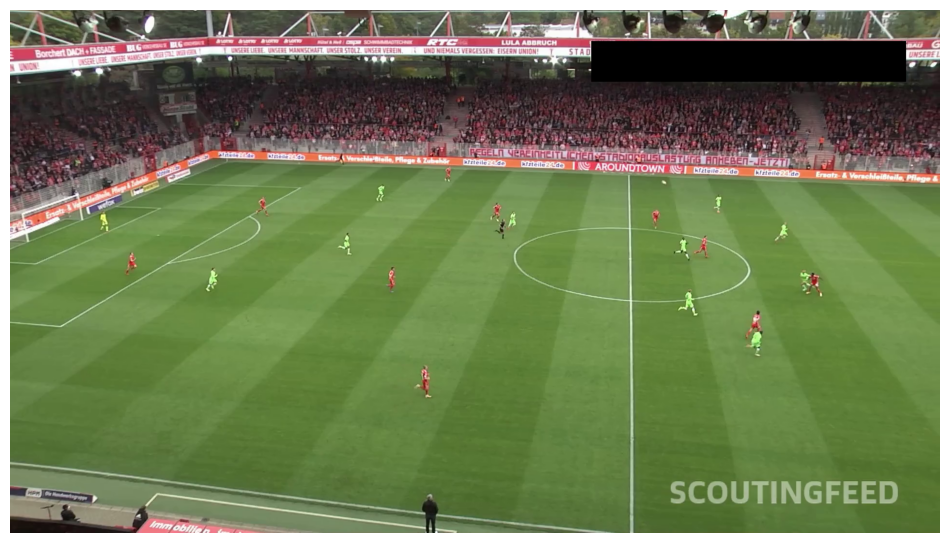

In [2]:
import supervision as sv

SOURCE_VIDEO_PATH = "videos/121364_0.mp4"

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

sv.plot_image(frame)

### Detection on one frame

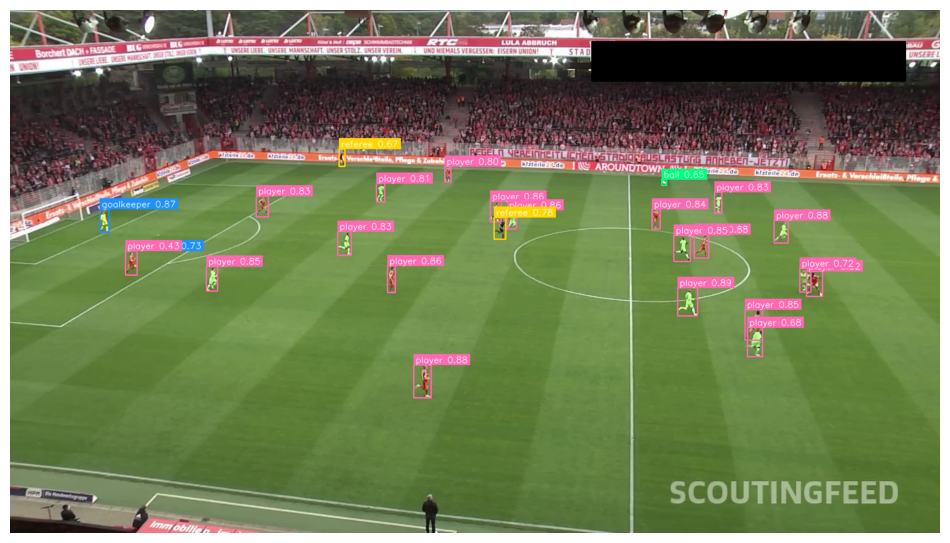

In [3]:
import supervision as sv

SOURCE_VIDEO_PATH = "videos/121364_0.mp4"

colors = ['#00FF7F', '#1E90FF', '#FF69B4',
          '#FFD700']

box_annotator = sv.BoxAnnotator(
    color=sv.ColorPalette.from_hex(colors),
    thickness=2
)

label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(colors),
    text_color=sv.Color.from_hex('#FFFFFF'),
    text_scale=0.6,
    text_thickness=1,
    text_padding=4
)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = yolo_finetuned_1280.predict(frame, conf=0.3, verbose=False)[0]
detections = sv.Detections.from_ultralytics(result)

labels = []
for class_name, confidence in zip(detections['class_name'], detections.confidence):
    label = f"{class_name} {confidence:.2f}"
    labels.append(label)

annotated_frame = frame.copy()
annotated_frame = box_annotator.annotate(annotated_frame,detections=detections)
annotated_frame = label_annotator.annotate(annotated_frame, detections=detections,
                  labels=labels)

sv.plot_image(annotated_frame)

### Detection on full video

In [ ]:
import os
import supervision as sv
from tqdm import tqdm
import cv2


def add_frame_annotation(frame, frame_number):

    height, width = frame.shape[:2]
    
    frame_text = f"Frame {frame_number}"
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.8
    font_thickness = 2
    text_color = (255, 255, 255) 
    bg_color = (0, 0, 0)  
    
    (text_width, text_height), baseline = cv2.getTextSize(frame_text, font, font_scale, font_thickness)
    

    padding = 10
    text_x = width - text_width - padding
    text_y = text_height + padding
    
    bg_x1 = text_x - 5
    bg_y1 = text_y - text_height - 5
    bg_x2 = text_x + text_width + 5
    bg_y2 = text_y + baseline + 5
    
    cv2.rectangle(frame, (bg_x1, bg_y1), (bg_x2, bg_y2), bg_color, -1)

    cv2.putText(frame, frame_text, (text_x, text_y), font, font_scale, text_color, font_thickness)
    
    return frame

def process_video_detection(video_src, detection_model, out_folder, frame_interval=100):
    filename = os.path.basename(video_src)
    name, _ = os.path.splitext(filename)

    annotated_video_path = f"result/{out_folder}/detection/{name}_detection.mp4"
    frame_output_dir = f"result/{out_folder}/detection/{name}_frames"
    os.makedirs(frame_output_dir, exist_ok=True)
    os.makedirs(os.path.dirname(annotated_video_path), exist_ok=True)

    colors = ['#00FF7F', '#1E90FF', '#FF69B4', '#FFD700']
    box_annotator = sv.BoxAnnotator(
        color=sv.ColorPalette.from_hex(colors),
        thickness=2
    )
    label_annotator = sv.LabelAnnotator(
        color=sv.ColorPalette.from_hex(colors),
        text_color=sv.Color.from_hex('#FFFFFF'),
        text_scale=0.6,
        text_thickness=1,
        text_padding=4
    )

    source_info = sv.VideoInfo.from_video_path(video_src)
    video_sink = sv.VideoSink(annotated_video_path, video_info=source_info)
    frame_generator = sv.get_video_frames_generator(video_src)

    with video_sink:
        for frame_index, frame in enumerate(tqdm(frame_generator, total=source_info.total_frames)):
            result = detection_model.predict(frame, conf=0.3, verbose=False)[0]
            detections = sv.Detections.from_ultralytics(result)

            labels = []
            for class_name, confidence in zip(detections['class_name'], detections.confidence):
                label = f"{class_name} {confidence:.2f}"
                labels.append(label)

            annotated_frame = frame.copy()
            annotated_frame = box_annotator.annotate(annotated_frame, detections)
            annotated_frame = label_annotator.annotate(annotated_frame, detections, labels=labels)

            annotated_frame = add_frame_annotation(annotated_frame, frame_index + 1)
            
            # Save every nth annotated frame as image
            if frame_index % frame_interval == 0:
                frame_filename = os.path.join(frame_output_dir, f"{name}_frame_{frame_index}.jpg")
                cv2.imwrite(frame_filename, annotated_frame)

            video_sink.write_frame(annotated_frame)

In [10]:
%%time
video_folder = "videos"
for filename in os.listdir(video_folder):
    filepath = os.path.join(video_folder, filename)
    if filepath.endswith(".mp4") and "result" not in filepath:
        print("processing ", filepath)
        process_video_detection(filepath, yolo_finetuned_1280, "yolo_finetuned_1280")

processing  videos/08fd33_0.mp4


100%|██████████| 750/750 [00:33<00:00, 22.27it/s]


processing  videos/2e57b9_0.mp4


100%|██████████| 750/750 [00:33<00:00, 22.17it/s]


processing  videos/121364_0.mp4


100%|██████████| 750/750 [00:33<00:00, 22.52it/s]


processing  videos/0bfacc_0.mp4


100%|██████████| 750/750 [00:33<00:00, 22.24it/s]


processing  videos/573e61_0.mp4


100%|██████████| 750/750 [00:33<00:00, 22.27it/s]

CPU times: user 3min 3s, sys: 458 ms, total: 3min 3s
Wall time: 2min 48s


In [11]:
%%time
video_folder = "videos"
for filename in os.listdir(video_folder):
    filepath = os.path.join(video_folder, filename)
    if filepath.endswith(".mp4") and "result" not in filepath:
        print("processing ", filepath)
        process_video_detection(filepath, yolo_finetuned_640, "yolo_finetuned_640")

processing  videos/08fd33_0.mp4


100%|██████████| 750/750 [00:15<00:00, 47.57it/s]


processing  videos/2e57b9_0.mp4


100%|██████████| 750/750 [00:15<00:00, 49.11it/s]


processing  videos/121364_0.mp4


100%|██████████| 750/750 [00:14<00:00, 50.34it/s]


processing  videos/0bfacc_0.mp4


100%|██████████| 750/750 [00:15<00:00, 49.31it/s]


processing  videos/573e61_0.mp4


100%|██████████| 750/750 [00:15<00:00, 49.75it/s]

CPU times: user 1min 31s, sys: 441 ms, total: 1min 32s
Wall time: 1min 16s


## Team division

### Divide teams using embeddings

#### Crop player images from video using detection

In [12]:
from tqdm import tqdm

crop_stride = 30 # skip every 29 frames

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH, stride=crop_stride)
crops = []

for frame in tqdm(frame_generator):
    result = yolo_finetuned_1280.predict(frame, conf=0.3, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(result)
    detections = detections.with_nms(threshold=0.5, class_agnostic=True)

    frame_crops = []
    player_indices = []

    for i in range(len(detections)):
        if detections["class_name"][i] == "player":
            player_indices.append(i)

    player_detections = detections[player_indices]
    for xyxy in player_detections.xyxy:
        crop = sv.crop_image(frame, xyxy)
        crops.append(crop)
    crops.extend(frame_crops)

25it [00:01, 18.20it/s]


In [13]:
len(crops)

498

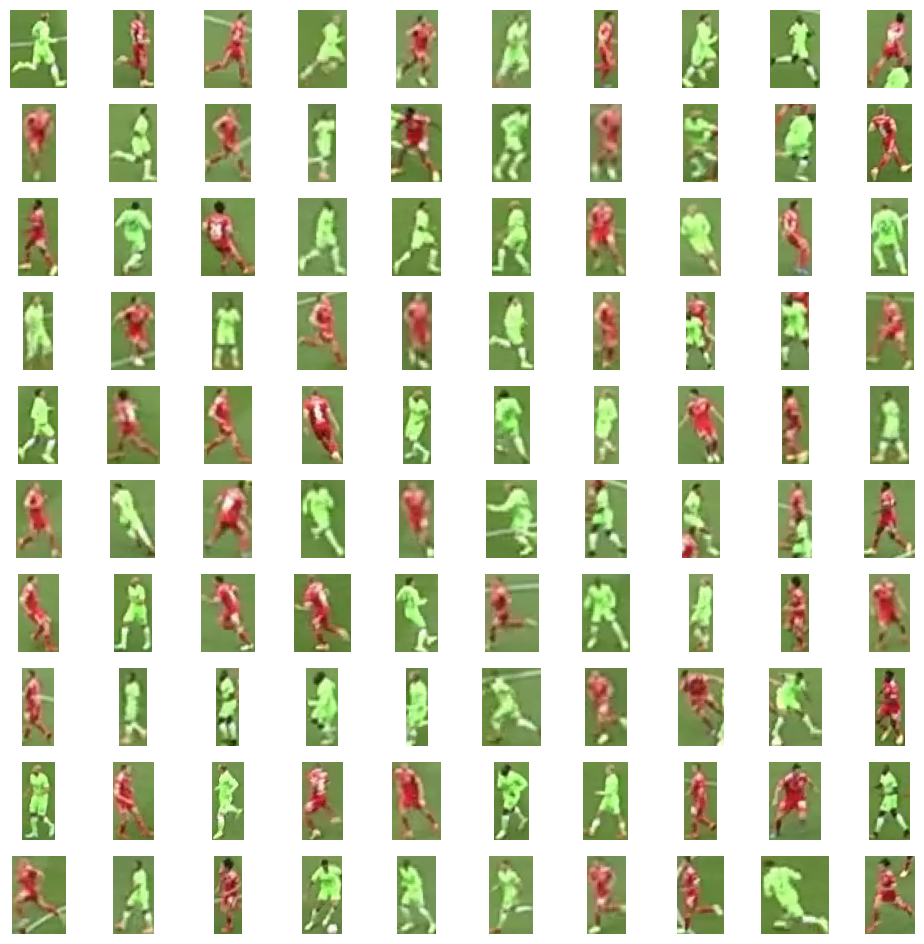

In [14]:
sv.plot_images_grid(crops[:100], grid_size=(10,10))

#### Load Siglip model from HuggingFace to create embeddings for crops

In [9]:
!pip install sentencepiece

Defaulting to user installation because normal site-packages is not writeable


In [15]:
import torch
from transformers import AutoProcessor, SiglipVisionModel

siglip_model_path = "google/siglip-base-patch16-224"

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
embeddings_model = SiglipVisionModel.from_pretrained(siglip_model_path).to(DEVICE)
embeddings_processor = AutoProcessor.from_pretrained(siglip_model_path)


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


#### Run Siglip on crops

In [16]:
import numpy as np
from more_itertools import chunked

batch_size = 32

# Convert to Pillow format (supervision uses opencv format but siglip uses Pillow)
crops_pillow = [sv.cv2_to_pillow(crop) for crop in crops]
batches = chunked(crops_pillow, batch_size)

data = []
with torch.no_grad():
    for batch in batches:
        inputs = embeddings_processor(images=batch, return_tensors='pt').to(DEVICE)
        outputs = embeddings_model(**inputs)
        embeddings = torch.mean(outputs.last_hidden_state, dim=1).cpu().numpy()
        data.append(embeddings)

    data = np.concatenate(data)

In [17]:
data.shape

(498, 768)

#### Reduce dimensions to 3 dimensions with UMAP

In [18]:
import umap

reducer = umap.UMAP(n_components=3)
projections = reducer.fit_transform(data)

In [19]:
projections.shape

(498, 3)

In [20]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(6, 5))
ax.scatter(projections[:, 0], projections[:, 1], projections[:, 2], s=6, alpha=0.7)
ax.set_title('UMAP of player crops (unlabeled)')
plt.show()


#### Cluster into 2 clusters (teams)

In [21]:
from sklearn.cluster import KMeans

clustering_model = KMeans(n_clusters=2)
clusters = clustering_model.fit_predict(projections)

1 or 0 depending on the team

In [22]:
clusters[:10]

array([1, 0, 0, 1, 0, 1, 0, 1, 1, 0], dtype=int32)

In [23]:
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    projections[:, 0], projections[:, 1], projections[:, 2],
    c=clusters, cmap='coolwarm', s=8, alpha=0.8
)
ax.set_title('UMAP of player crops (clustered)')
plt.show()


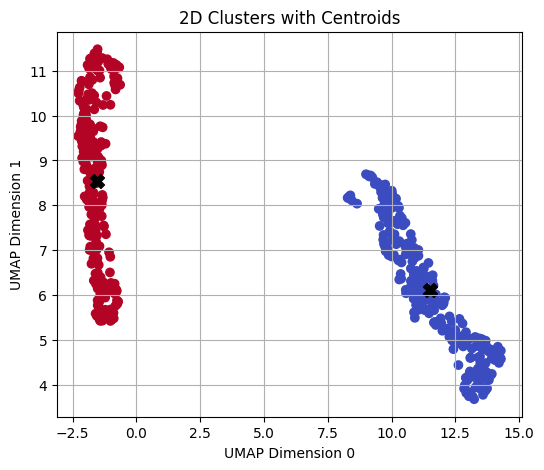

In [24]:
centroids_2d = clustering_model.cluster_centers_[:, :2]

plt.figure(figsize=(6, 5))
plt.scatter(projections[:, 0], projections[:, 1], c=clusters, cmap='coolwarm')
plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1], c='black', s=100, marker='X')
plt.title("2D Clusters with Centroids")
plt.xlabel("UMAP Dimension 0")
plt.ylabel("UMAP Dimension 1")
plt.grid(True)
plt.show()


In [25]:
team_0 = []
team_1 = []

for crop, cluster in zip(crops, clusters):
  if cluster == 0:
    team_0.append(crop)
  else:
    team_1.append(crop)

In [26]:
sv.plot_images_grid(team_0[:64], grid_size=(8,8))

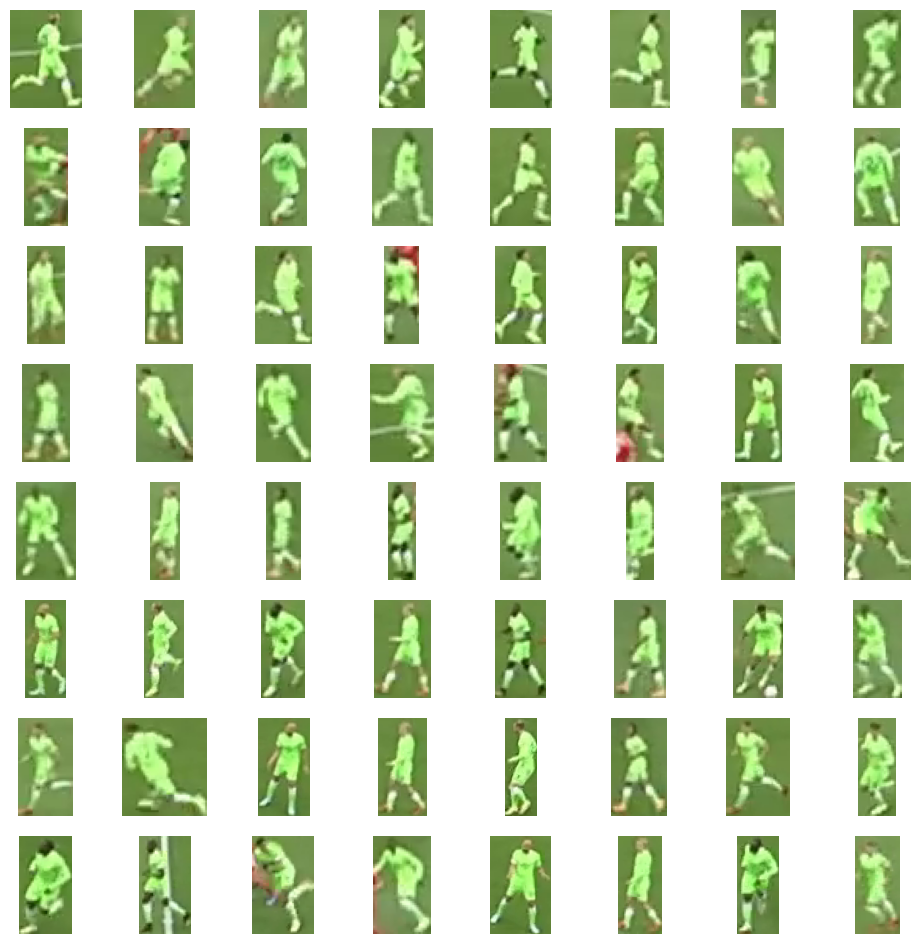

In [27]:
sv.plot_images_grid(team_1[:64], grid_size=(8,8))

#### Divide teams on full video with embeddings and goalkeeper heuristic

In [28]:
import os
import supervision as sv
from tqdm import tqdm
import cv2
import torch
import numpy as np
from more_itertools import chunked
from sklearn.cluster import KMeans
import umap


def bottom_center(dets: sv.Detections):
    """Bottom center anchor for each box."""
    return dets.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)

def assign_gk_to_team(players_det, gk_det):
    """Assign goalkeepers to nearest team centroid (players grouped by predicted team id in class_id)."""

    pxy = bottom_center(players_det)
    # team ids are in players_det.class_id (0/1)
    team0 = pxy[players_det.class_id == 0]
    team1 = pxy[players_det.class_id == 1]

    # Calculate centroids
    c0 = np.mean(team0, axis=0) if len(team0) > 0 else np.array([0, 0])
    c1 = np.mean(team1, axis=0) if len(team1) > 0 else np.array([0, 0])

    gxy = bottom_center(gk_det)
    out = []
    for g in gxy:
        d0 = np.linalg.norm(g - c0)
        d1 = np.linalg.norm(g - c1)
        out.append(0 if d0 <= d1 else 1)
    return np.array(out, dtype=int)

def extract_player_crops_from_detections(frame, detections):
    crops = []
    player_indices = []

    for i in range(len(detections)):
        if detections["class_name"][i] == "player":
            player_indices.append(i)

    player_detections = detections[player_indices]
    for xyxy in player_detections.xyxy:
        crop = sv.crop_image(frame, xyxy)
        crops.append(crop)

    return crops

def create_embeddings(crops, embeddings_model, embeddings_processor, device, batch_size=32):

    # Convert to Pillow format (supervision uses opencv format but siglip uses Pillow)
    crops_pillow = [sv.cv2_to_pillow(crop) for crop in crops]
    batches = chunked(crops_pillow, batch_size)

    data = []
    with torch.no_grad():
        for batch in batches:
            inputs = embeddings_processor(images=batch, return_tensors='pt').to(device)
            outputs = embeddings_model(**inputs)
            embeddings = torch.mean(outputs.last_hidden_state, dim=1).cpu().numpy()
            data.append(embeddings)

    return np.concatenate(data)

def reduce_dimensions_umap(embeddings, n_components=3):
    reducer = umap.UMAP(n_components=n_components)
    projections = reducer.fit_transform(embeddings)
    return projections, reducer

def cluster_players_kmeans(projections, n_clusters=2):
    clustering_model = KMeans(n_clusters=n_clusters)
    clusters = clustering_model.fit_predict(projections)
    return clusters, clustering_model

def assign_team_labels(clusters):
    team_mapping = {0: "#A", 1: "#B"}
    return [team_mapping.get(cluster) for cluster in clusters]

def predict_team_for_crops_embedding(crops, embeddings_model, embeddings_processor, umap_reducer, kmeans_model, device):
    """Predict team for new crops using trained models."""
    embeddings = create_embeddings(crops, embeddings_model, embeddings_processor, device)

    projections = umap_reducer.transform(embeddings)

    clusters = kmeans_model.predict(projections)

    return assign_team_labels(clusters)

def process_video_team_division_embedding(video_src, detection_model, out_folder, embeddings_model, embeddings_processor,
                               frame_interval=100, crop_stride=30, device='cuda'):

    filename = os.path.basename(video_src)
    name, _ = os.path.splitext(filename)
    annotated_video_path = f"result/{out_folder}/team_division_embedding/{name}_team_division.mp4"
    frame_output_dir = f"result/{out_folder}/team_division_embedding/{name}_frames"

    os.makedirs(frame_output_dir, exist_ok=True)
    os.makedirs(os.path.dirname(annotated_video_path), exist_ok=True)

    # Separate annotators
    team_a_box = sv.BoxAnnotator(color=sv.Color.from_hex('#FF69B4'), thickness=2)
    team_b_box = sv.BoxAnnotator(color=sv.Color.from_hex('#00BFFF'), thickness=2)
    ball_box = sv.BoxAnnotator(color=sv.Color.from_hex('#00FF7F'), thickness=2)
    referee_box = sv.BoxAnnotator(color=sv.Color.from_hex('#FFD700'), thickness=2)

    team_a_label = sv.LabelAnnotator(color=sv.Color.from_hex('#FF69B4'), text_color=sv.Color.from_hex('#FFFFFF'), text_scale=0.6, text_thickness=1, text_padding=4)
    team_b_label = sv.LabelAnnotator(color=sv.Color.from_hex('#00BFFF'), text_color=sv.Color.from_hex('#FFFFFF'), text_scale=0.6, text_thickness=1, text_padding=4)
    ball_label = sv.LabelAnnotator(color=sv.Color.from_hex('#00FF7F'), text_color=sv.Color.from_hex('#FFFFFF'), text_scale=0.6, text_thickness=1, text_padding=4)
    referee_label = sv.LabelAnnotator(color=sv.Color.from_hex('#FFD700'), text_color=sv.Color.from_hex('#FFFFFF'), text_scale=0.6, text_thickness=1, text_padding=4)


    # Get crops for team assignment training
    frame_generator = sv.get_video_frames_generator(video_src, stride=crop_stride)
    all_crops = []

    for frame in tqdm(frame_generator, desc="Collecting crops"):
        result = detection_model.predict(frame, conf=0.3, verbose=False)[0]
        detections = sv.Detections.from_ultralytics(result)
        detections = detections.with_nms(threshold=0.5, class_agnostic=True)

        frame_crops = extract_player_crops_from_detections(frame, detections)
        all_crops.extend(frame_crops)

    # Train team assignment models
    embeddings = create_embeddings(all_crops, embeddings_model, embeddings_processor, device)
    projections, umap_reducer = reduce_dimensions_umap(embeddings)
    clusters, kmeans_model = cluster_players_kmeans(projections)

    # Process video with team labels
    source_info = sv.VideoInfo.from_video_path(video_src)
    video_sink = sv.VideoSink(annotated_video_path, video_info=source_info)
    frame_generator = sv.get_video_frames_generator(video_src)

    with video_sink:
        for frame_index, frame in enumerate(tqdm(frame_generator, total=source_info.total_frames)):
            result = detection_model.predict(frame, conf=0.3, verbose=False)[0]
            detections = sv.Detections.from_ultralytics(result)
            detections = detections.with_nms(threshold=0.5, class_agnostic=True)

            # Separate detections by class
            player_indices = []
            gk_indices = []
            other_indices = []

            for i in range(len(detections)):
                class_name = detections["class_name"][i]
                if class_name == "player":
                    player_indices.append(i)
                elif class_name == "goalkeeper":
                    gk_indices.append(i)
                else:
                    other_indices.append(i)

            labels = []

            # Process players with team assignment
            if player_indices:
                player_detections = detections[player_indices]
                player_crops = extract_player_crops_from_detections(frame, player_detections)
                team_labels = predict_team_for_crops_embedding(player_crops, embeddings_model, embeddings_processor,
                                                   umap_reducer, kmeans_model, device)

                # Store team assignments in class_id for goalkeeper assignment
                team_ids = [0 if label == "#A" else 1 for label in team_labels]
                player_detections.class_id = np.array(team_ids)

                # Create labels for players
                for i, (class_name, confidence, team_label) in enumerate(zip(
                    player_detections['class_name'],
                    player_detections.confidence,
                    team_labels
                )):
                    label = f"{class_name} {team_label} {confidence:.2f}"
                    labels.append((player_indices[i], label))

            # Process goalkeepers with team assignment
            if gk_indices and player_indices:
                gk_detections = detections[gk_indices]
                gk_teams = assign_gk_to_team(player_detections, gk_detections)
                gk_team_labels = assign_team_labels(gk_teams)

                # Create labels for goalkeepers
                for i, (class_name, confidence, team_label) in enumerate(zip(
                    gk_detections['class_name'],
                    gk_detections.confidence,
                    gk_team_labels
                )):
                    label = f"{class_name} {team_label} {confidence:.2f}"
                    labels.append((gk_indices[i], label))
            elif gk_indices:
                # No players found, use original labels for goalkeepers
                for i, (class_name, confidence) in enumerate(zip(
                    detections[gk_indices]['class_name'],
                    detections[gk_indices].confidence
                )):
                    label = f"{class_name} {confidence:.2f}"
                    labels.append((gk_indices[i], label))

            # Process other classes (ball, referee) with original labels
            for i in other_indices:
                class_name = detections["class_name"][i]
                confidence = detections.confidence[i]
                label = f"{class_name} {confidence:.2f}"
                labels.append((i, label))

            # Sort labels by detection index and extract label strings
            labels.sort(key=lambda x: x[0])
            label_strings = [label[1] for label in labels]

            annotated_frame = frame.copy()

            # Separate detections by team/class and annotate each group
            team_a_indices = [i for i, label in enumerate(label_strings) if "#A" in label]
            team_b_indices = [i for i, label in enumerate(label_strings) if "#B" in label]
            ball_indices = [i for i, label in enumerate(label_strings) if detections["class_name"][i] == "ball"]
            referee_indices = [i for i, label in enumerate(label_strings) if detections["class_name"][i] == "referee"]

            if team_a_indices:
                annotated_frame = team_a_box.annotate(annotated_frame, detections[team_a_indices])
                annotated_frame = team_a_label.annotate(annotated_frame, detections[team_a_indices], labels=[label_strings[i] for i in team_a_indices])

            if team_b_indices:
                annotated_frame = team_b_box.annotate(annotated_frame, detections[team_b_indices])
                annotated_frame = team_b_label.annotate(annotated_frame, detections[team_b_indices], labels=[label_strings[i] for i in team_b_indices])

            if ball_indices:
                annotated_frame = ball_box.annotate(annotated_frame, detections[ball_indices])
                annotated_frame = ball_label.annotate(annotated_frame, detections[ball_indices], labels=[label_strings[i] for i in ball_indices])

            if referee_indices:
                annotated_frame = referee_box.annotate(annotated_frame, detections[referee_indices])
                annotated_frame = referee_label.annotate(annotated_frame, detections[referee_indices], labels=[label_strings[i] for i in referee_indices])

            annotated_frame = add_frame_annotation(annotated_frame, frame_index + 1)    

            # Save every nth annotated frame as image
            if frame_index % frame_interval == 0:
                frame_filename = os.path.join(frame_output_dir, f"{name}_frame_{frame_index}.jpg")
                cv2.imwrite(frame_filename, annotated_frame)

            video_sink.write_frame(annotated_frame)

In [30]:
%%time

video_folder = "videos"
for filename in os.listdir(video_folder):
    filepath = os.path.join(video_folder, filename)
    if filepath.endswith(".mp4") and "result" not in filepath:
        print("processing ", filepath)
        process_video_team_division_embedding(
            filepath,
            yolo_finetuned_1280,
            "yolo_finetuned_1280",
            embeddings_model,
            embeddings_processor,
        )

processing  videos/08fd33_0.mp4


100%|██████████| 750/750 [01:55<00:00,  6.52it/s]


processing  videos/2e57b9_0.mp4


100%|██████████| 750/750 [01:54<00:00,  6.58it/s]


processing  videos/121364_0.mp4


100%|██████████| 750/750 [01:53<00:00,  6.63it/s]


processing  videos/0bfacc_0.mp4


100%|██████████| 750/750 [02:09<00:00,  5.80it/s]


processing  videos/573e61_0.mp4


100%|██████████| 750/750 [02:00<00:00,  6.24it/s]

CPU times: user 16min 44s, sys: 30.5 s, total: 17min 14s
Wall time: 10min 11s


In [31]:
%%time

video_folder = "videos"
for filename in os.listdir(video_folder):
    filepath = os.path.join(video_folder, filename)
    if filepath.endswith(".mp4") and "result" not in filepath:
        print("processing ", filepath)
        process_video_team_division_embedding(
            filepath,
            yolo_finetuned_640,
            "yolo_finetuned_640",
            embeddings_model,
            embeddings_processor,
        )

processing  videos/08fd33_0.mp4


100%|██████████| 750/750 [01:35<00:00,  7.84it/s]


processing  videos/2e57b9_0.mp4


100%|██████████| 750/750 [01:30<00:00,  8.28it/s]


processing  videos/121364_0.mp4


100%|██████████| 750/750 [01:33<00:00,  8.04it/s]


processing  videos/0bfacc_0.mp4


100%|██████████| 750/750 [01:31<00:00,  8.16it/s]


processing  videos/573e61_0.mp4


100%|██████████| 750/750 [01:30<00:00,  8.25it/s]

CPU times: user 14min 51s, sys: 31.1 s, total: 15min 23s
Wall time: 7min 58s


### Divide teams using RGB color based clustering

In [32]:
rgb_features = []

for crop in crops:
    # Focus on jersey area (upper 60% of crop)
    height = crop.shape[0]
    jersey_area = crop[:int(height * 0.6), :]
    
    # Calculate mean RGB values for jersey area
    mean_rgb = np.mean(jersey_area.reshape(-1, 3), axis=0)
    
    std_rgb = np.std(jersey_area.reshape(-1, 3), axis=0)
    
    rgb_feature = np.concatenate([mean_rgb, std_rgb])
    rgb_features.append(rgb_feature)

rgb_features = np.array(rgb_features)

In [33]:
rgb_features.shape

(498, 6)

#### Reduce dimenstions to 3 with UMAP

In [34]:
rgb_projections, rgb_umap_reducer = reduce_dimensions_umap(rgb_features)

rgb_projections.shape

(498, 3)

In [35]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(6, 5))
ax.scatter(rgb_projections[:, 0], rgb_projections[:, 1], rgb_projections[:, 2], s=6, alpha=0.7)
ax.set_title('UMAP of player RGB features (unlabeled)')
plt.show()

#### Cluster into 2 clusters (teams)

In [36]:
rgb_clusters, rgb_kmeans_model = cluster_players_kmeans(rgb_projections)

1 or 0 depending on the team

In [37]:
rgb_clusters[:10]

array([0, 1, 1, 0, 1, 0, 1, 0, 0, 1], dtype=int32)

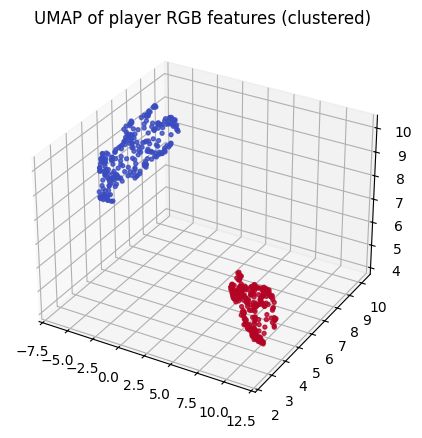

In [38]:
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    rgb_projections[:, 0], rgb_projections[:, 1], rgb_projections[:, 2],
    c=rgb_clusters, cmap='coolwarm', s=8, alpha=0.8
)
ax.set_title('UMAP of player RGB features (clustered)')
plt.show()

In [39]:
rgb_team_0 = []
rgb_team_1 = []

for crop, cluster in zip(crops, rgb_clusters):
    if cluster == 0:
        rgb_team_0.append(crop)
    else:
        rgb_team_1.append(crop)

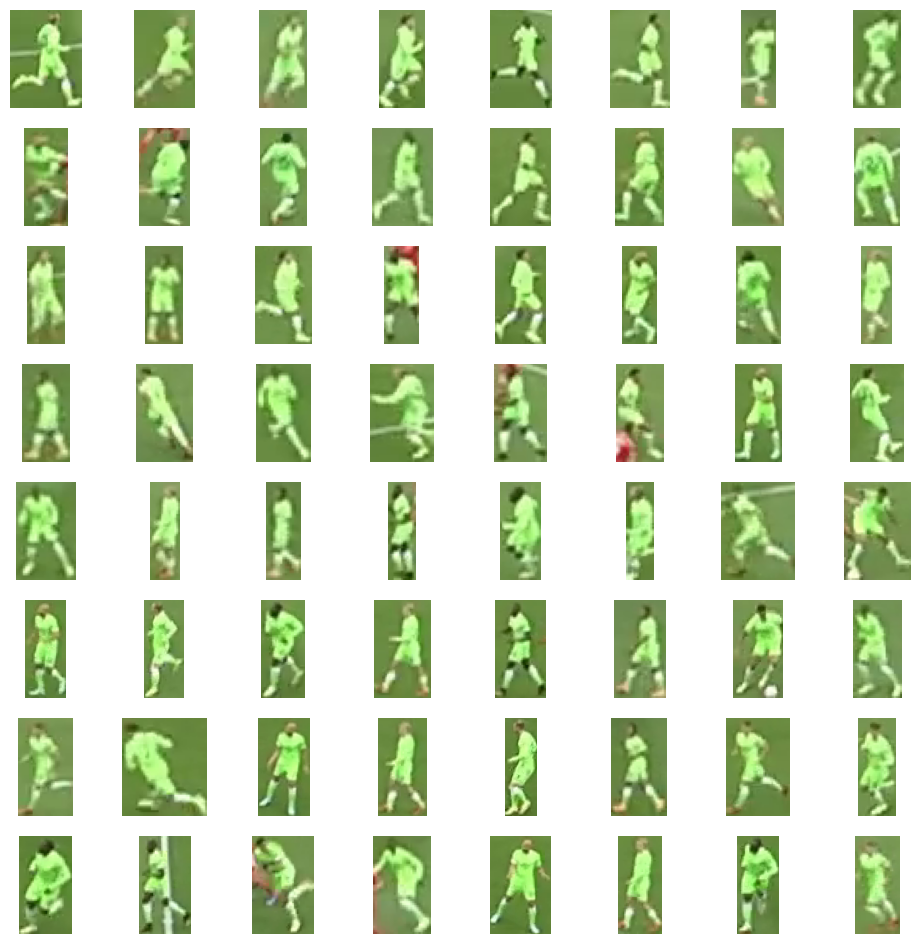

In [40]:
sv.plot_images_grid(rgb_team_0[:64], grid_size=(8,8))

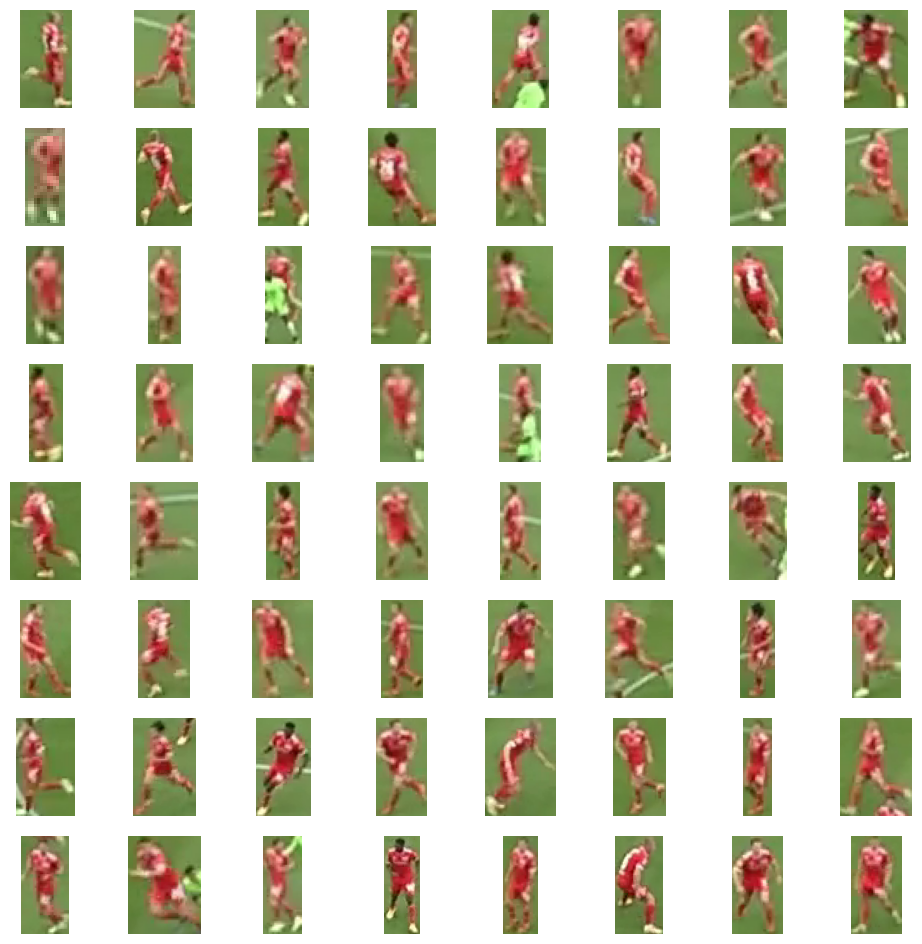

In [41]:
sv.plot_images_grid(rgb_team_1[:64], grid_size=(8,8))

#### Divide teams on full video using RGB features and goalkeeper heuristic

In [42]:
def create_rgb_color_features(crops):
    rgb_features = []
    
    for crop in crops:
        # Focus on jersey area (upper 60% of crop)
        height = crop.shape[0]
        jersey_area = crop[:int(height * 0.6), :]
        
        # Calculate mean RGB values for jersey area
        mean_rgb = np.mean(jersey_area.reshape(-1, 3), axis=0)
        
        std_rgb = np.std(jersey_area.reshape(-1, 3), axis=0)
        
        rgb_feature = np.concatenate([mean_rgb, std_rgb])
        rgb_features.append(rgb_feature)
    
    return np.array(rgb_features)


def predict_team_for_crops_rgb(crops, umap_reducer, kmeans_model):
    rgb_features = create_rgb_color_features(crops)
    projections = umap_reducer.transform(rgb_features)
    clusters = kmeans_model.predict(projections)
    return assign_team_labels(clusters)


def process_video_team_division_rgb(video_src, detection_model, out_folder, frame_interval=100, crop_stride=30):
    
    filename = os.path.basename(video_src)
    name, _ = os.path.splitext(filename)
    annotated_video_path = f"result/{out_folder}/team_division_rgb/{name}_team_division_rgb.mp4"
    frame_output_dir = f"result/{out_folder}/team_division_rgb/{name}_frames"

    os.makedirs(frame_output_dir, exist_ok=True)
    os.makedirs(os.path.dirname(annotated_video_path), exist_ok=True)

    # Separate annotators
    team_a_box = sv.BoxAnnotator(color=sv.Color.from_hex('#FF69B4'), thickness=2)
    team_b_box = sv.BoxAnnotator(color=sv.Color.from_hex('#00BFFF'), thickness=2)
    ball_box = sv.BoxAnnotator(color=sv.Color.from_hex('#00FF7F'), thickness=2)
    referee_box = sv.BoxAnnotator(color=sv.Color.from_hex('#FFD700'), thickness=2)

    team_a_label = sv.LabelAnnotator(color=sv.Color.from_hex('#FF69B4'), text_color=sv.Color.from_hex('#FFFFFF'), text_scale=0.6, text_thickness=1, text_padding=4)
    team_b_label = sv.LabelAnnotator(color=sv.Color.from_hex('#00BFFF'), text_color=sv.Color.from_hex('#FFFFFF'), text_scale=0.6, text_thickness=1, text_padding=4)
    ball_label = sv.LabelAnnotator(color=sv.Color.from_hex('#00FF7F'), text_color=sv.Color.from_hex('#FFFFFF'), text_scale=0.6, text_thickness=1, text_padding=4)
    referee_label = sv.LabelAnnotator(color=sv.Color.from_hex('#FFD700'), text_color=sv.Color.from_hex('#FFFFFF'), text_scale=0.6, text_thickness=1, text_padding=4)

    # Get crops for team assignment training 
    frame_generator = sv.get_video_frames_generator(video_src, stride=crop_stride)
    all_crops = []

    for frame in tqdm(frame_generator, desc="Collecting crops"):
        result = detection_model.predict(frame, conf=0.3, verbose=False)[0]
        detections = sv.Detections.from_ultralytics(result)
        detections = detections.with_nms(threshold=0.5, class_agnostic=True)

        frame_crops = extract_player_crops_from_detections(frame, detections)
        all_crops.extend(frame_crops)


    rgb_features = create_rgb_color_features(all_crops)  
    projections, umap_reducer = reduce_dimensions_umap(rgb_features) 
    clusters, kmeans_model = cluster_players_kmeans(projections)  

    # Process video with team labels
    source_info = sv.VideoInfo.from_video_path(video_src)
    video_sink = sv.VideoSink(annotated_video_path, video_info=source_info)
    frame_generator = sv.get_video_frames_generator(video_src)

    with video_sink:
        for frame_index, frame in enumerate(tqdm(frame_generator, total=source_info.total_frames)):
            result = detection_model.predict(frame, conf=0.3, verbose=False)[0]
            detections = sv.Detections.from_ultralytics(result)
            detections = detections.with_nms(threshold=0.5, class_agnostic=True)

            # Separate detections by class 
            player_indices = []
            gk_indices = []
            other_indices = []

            for i in range(len(detections)):
                class_name = detections["class_name"][i]
                if class_name == "player":
                    player_indices.append(i)
                elif class_name == "goalkeeper":
                    gk_indices.append(i)
                else:
                    other_indices.append(i)

            labels = []

            # Process players (RGB based team assignment)
            if player_indices:
                player_detections = detections[player_indices]
                player_crops = extract_player_crops_from_detections(frame, player_detections)
                team_labels = predict_team_for_crops_rgb(player_crops, umap_reducer, kmeans_model)

                # Store team assignments in class_id for goalkeeper assignment
                team_ids = [0 if label == "#A" else 1 for label in team_labels]
                player_detections.class_id = np.array(team_ids)

                # Create labels for players
                for i, (class_name, confidence, team_label) in enumerate(zip(
                    player_detections['class_name'],
                    player_detections.confidence,
                    team_labels
                )):
                    label = f"{class_name} {team_label} {confidence:.2f}"
                    labels.append((player_indices[i], label))

            # Process goalkeepers with team assignment
            if gk_indices and player_indices:
                gk_detections = detections[gk_indices]
                gk_teams = assign_gk_to_team(player_detections, gk_detections) 
                gk_team_labels = assign_team_labels(gk_teams)

                # Create labels for goalkeepers
                for i, (class_name, confidence, team_label) in enumerate(zip(
                    gk_detections['class_name'],
                    gk_detections.confidence,
                    gk_team_labels
                )):
                    label = f"{class_name} {team_label} {confidence:.2f}"
                    labels.append((gk_indices[i], label))
            elif gk_indices:
                # No players found, use original labels for goalkeepers
                for i, (class_name, confidence) in enumerate(zip(
                    detections[gk_indices]['class_name'],
                    detections[gk_indices].confidence
                )):
                    label = f"{class_name} {confidence:.2f}"
                    labels.append((gk_indices[i], label))

            # Process other classes (ball, referee) with original labels
            for i in other_indices:
                class_name = detections["class_name"][i]
                confidence = detections.confidence[i]
                label = f"{class_name} {confidence:.2f}"
                labels.append((i, label))

            # Sort labels by detection index and extract label strings
            labels.sort(key=lambda x: x[0])
            label_strings = [label[1] for label in labels]

            annotated_frame = frame.copy()

            # Separate detections by team/class and annotate each group
            team_a_indices = [i for i, label in enumerate(label_strings) if "#A" in label]
            team_b_indices = [i for i, label in enumerate(label_strings) if "#B" in label]
            ball_indices = [i for i, label in enumerate(label_strings) if detections["class_name"][i] == "ball"]
            referee_indices = [i for i, label in enumerate(label_strings) if detections["class_name"][i] == "referee"]

            if team_a_indices:
                annotated_frame = team_a_box.annotate(annotated_frame, detections[team_a_indices])
                annotated_frame = team_a_label.annotate(annotated_frame, detections[team_a_indices], labels=[label_strings[i] for i in team_a_indices])

            if team_b_indices:
                annotated_frame = team_b_box.annotate(annotated_frame, detections[team_b_indices])
                annotated_frame = team_b_label.annotate(annotated_frame, detections[team_b_indices], labels=[label_strings[i] for i in team_b_indices])

            if ball_indices:
                annotated_frame = ball_box.annotate(annotated_frame, detections[ball_indices])
                annotated_frame = ball_label.annotate(annotated_frame, detections[ball_indices], labels=[label_strings[i] for i in ball_indices])

            if referee_indices:
                annotated_frame = referee_box.annotate(annotated_frame, detections[referee_indices])
                annotated_frame = referee_label.annotate(annotated_frame, detections[referee_indices], labels=[label_strings[i] for i in referee_indices])

            # Add frame number annotation
            annotated_frame = add_frame_annotation(annotated_frame, frame_index + 1)

            # Save every nth annotated frame as image
            if frame_index % frame_interval == 0:
                frame_filename = os.path.join(frame_output_dir, f"{name}_frame_{frame_index}.jpg")
                cv2.imwrite(frame_filename, annotated_frame)

            video_sink.write_frame(annotated_frame)

In [43]:
%%time

video_folder = "videos"
for filename in os.listdir(video_folder):
    filepath = os.path.join(video_folder, filename)
    if filepath.endswith(".mp4") and "result" not in filepath:
        print("processing ", filepath)
        process_video_team_division_rgb(
            filepath,
            yolo_finetuned_1280,
            "yolo_finetuned_1280"
        )

processing  videos/08fd33_0.mp4


100%|██████████| 750/750 [00:43<00:00, 17.18it/s]


processing  videos/2e57b9_0.mp4


100%|██████████| 750/750 [00:43<00:00, 17.32it/s]


processing  videos/121364_0.mp4


100%|██████████| 750/750 [00:43<00:00, 17.43it/s]


processing  videos/0bfacc_0.mp4


100%|██████████| 750/750 [00:43<00:00, 17.42it/s]


processing  videos/573e61_0.mp4


100%|██████████| 750/750 [00:43<00:00, 17.38it/s]

CPU times: user 9min 24s, sys: 27.5 s, total: 9min 52s
Wall time: 3min 43s


In [44]:
%%time

video_folder = "videos"
for filename in os.listdir(video_folder):
    filepath = os.path.join(video_folder, filename)
    if filepath.endswith(".mp4") and "result" not in filepath:
        print("processing ", filepath)
        process_video_team_division_rgb(
            filepath,
            yolo_finetuned_640,
            "yolo_finetuned_640"
        )

processing  videos/08fd33_0.mp4


100%|██████████| 750/750 [00:25<00:00, 29.29it/s]


processing  videos/2e57b9_0.mp4


100%|██████████| 750/750 [00:24<00:00, 30.56it/s]


processing  videos/121364_0.mp4


100%|██████████| 750/750 [00:24<00:00, 30.19it/s]


processing  videos/0bfacc_0.mp4


100%|██████████| 750/750 [00:24<00:00, 30.43it/s]


processing  videos/573e61_0.mp4


100%|██████████| 750/750 [00:24<00:00, 30.66it/s]

CPU times: user 7min 50s, sys: 26.9 s, total: 8min 17s
Wall time: 2min 8s


## Ball interpolation

The ball is often missing in some frames. The solution is interpolation where we use the ball's known positions from detected frames to estimate its location in missing frames.

In [45]:
import pandas as pd


def collect_and_interpolate_ball_positions(video_src, detection_model):
    source_info = sv.VideoInfo.from_video_path(video_src)
    frame_generator = sv.get_video_frames_generator(video_src)
    ball_positions_list = []

    for frame in tqdm(frame_generator, total=source_info.total_frames):
        result = detection_model.predict(frame, conf=0.3, verbose=False)[0]
        detections = sv.Detections.from_ultralytics(result)
        detections = detections.with_nms(threshold=0.5, class_agnostic=True)

        ball_found = False
        for i in range(len(detections)):
            if detections["class_name"][i] == "ball":
                bbox = detections.xyxy[i]
                ball_positions_list.append(bbox.tolist())
                ball_found = True
                break

        if not ball_found:
            ball_positions_list.append([np.nan, np.nan, np.nan, np.nan])

    missing_before = sum(1 for pos in ball_positions_list if np.isnan(pos[0]))

    # Interpolate using pandas
    df_ball_positions = pd.DataFrame(
        ball_positions_list,
        columns=['x1', 'y1', 'x2', 'y2']
    )

    # Interpolate missing values
    df_ball_positions = df_ball_positions.interpolate(method='linear')
    df_ball_positions = df_ball_positions.bfill()
    df_ball_positions = df_ball_positions.ffill()

    interpolated_positions = df_ball_positions.to_numpy().tolist()

    missing_after = sum(1 for pos in interpolated_positions if np.isnan(pos[0]))

    stats = {
        'total_frames': source_info.total_frames,
        'missing_detections': missing_before,
        'frames_interpolated': missing_before - missing_after,
    }

    print(f"\nBall Detection Statistics:")
    print(f"Total frames: {stats['total_frames']}")
    print(f"Frames where ball was not detected: {stats['missing_detections']}")
    print(f"Frames saved by interpolation: {stats['frames_interpolated']}")

    return interpolated_positions


def draw_interpolated_ball(frame, ball_position):
    x1, y1, x2, y2 = [int(coord) for coord in ball_position]

    cv2.rectangle(frame, (x1, y1), (x2, y2), (127, 255, 0), 2)

    label_text = "ball (interpolated)"
    label_size, _ = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)
    label_x = x1
    label_y = y1 - 10 if y1 - 10 > 0 else y1 + label_size[1] + 10

    cv2.rectangle(frame,
                (label_x, label_y - label_size[1] - 4),
                (label_x + label_size[0] + 8, label_y + 4),
                (127, 255, 0), -1)
    cv2.putText(frame, label_text,
              (label_x + 4, label_y),
              cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)

    return frame


def process_video_with_ball_interpolation(video_src, detection_model, out_folder, embeddings_model, embeddings_processor,
                                         frame_interval=100, crop_stride=30, device='cuda'):

    filename = os.path.basename(video_src)
    name, _ = os.path.splitext(filename)
    annotated_video_path = f"result/{out_folder}/ball_interpolation/{name}_ball_interpolation.mp4"
    frame_output_dir = f"result/{out_folder}/ball_interpolation/{name}_frames"

    os.makedirs(frame_output_dir, exist_ok=True)
    os.makedirs(os.path.dirname(annotated_video_path), exist_ok=True)

    team_a_box = sv.BoxAnnotator(color=sv.Color.from_hex('#FF69B4'), thickness=2)
    team_b_box = sv.BoxAnnotator(color=sv.Color.from_hex('#00BFFF'), thickness=2)
    ball_box = sv.BoxAnnotator(color=sv.Color.from_hex('#00FF7F'), thickness=2)
    referee_box = sv.BoxAnnotator(color=sv.Color.from_hex('#FFD700'), thickness=2)
    team_a_label = sv.LabelAnnotator(color=sv.Color.from_hex('#FF69B4'), text_color=sv.Color.from_hex('#FFFFFF'), text_scale=0.4, text_thickness=1, text_padding=4)
    team_b_label = sv.LabelAnnotator(color=sv.Color.from_hex('#00BFFF'), text_color=sv.Color.from_hex('#FFFFFF'), text_scale=0.4, text_thickness=1, text_padding=4)
    ball_label = sv.LabelAnnotator(color=sv.Color.from_hex('#00FF7F'), text_color=sv.Color.from_hex('#FFFFFF'), text_scale=0.4, text_thickness=1, text_padding=4)
    referee_label = sv.LabelAnnotator(color=sv.Color.from_hex('#FFD700'), text_color=sv.Color.from_hex('#FFFFFF'), text_scale=0.4, text_thickness=1, text_padding=4)
    # Get crops for team assignment training
    frame_generator = sv.get_video_frames_generator(video_src, stride=crop_stride)
    all_crops = []

    for frame in tqdm(frame_generator, desc="Collecting crops"):
        result = detection_model.predict(frame, conf=0.3, verbose=False)[0]
        detections = sv.Detections.from_ultralytics(result)
        detections = detections.with_nms(threshold=0.5, class_agnostic=True)

        frame_crops = extract_player_crops_from_detections(frame, detections)
        all_crops.extend(frame_crops)

    # Train team assignment models
    embeddings = create_embeddings(all_crops, embeddings_model, embeddings_processor, device)
    projections, umap_reducer = reduce_dimensions_umap(embeddings)
    clusters, kmeans_model = cluster_players_kmeans(projections)

    # Collect and interpolate ball positions
    interpolated_ball_positions = collect_and_interpolate_ball_positions(video_src, detection_model)

    # Process video with team labels and interpolated ball
    source_info = sv.VideoInfo.from_video_path(video_src)
    video_sink = sv.VideoSink(annotated_video_path, video_info=source_info)
    frame_generator = sv.get_video_frames_generator(video_src)

    with video_sink:
        for frame_index, frame in enumerate(tqdm(frame_generator, total=source_info.total_frames)):
            result = detection_model.predict(frame, conf=0.3, verbose=False)[0]
            detections = sv.Detections.from_ultralytics(result)
            detections = detections.with_nms(threshold=0.5, class_agnostic=True)

            # Separate detections by class
            player_indices = []
            gk_indices = []
            ball_indices = []
            referee_indices = []

            for i in range(len(detections)):
                class_name = detections["class_name"][i]
                if class_name == "player":
                    player_indices.append(i)
                elif class_name == "goalkeeper":
                    gk_indices.append(i)
                elif class_name == "ball":
                    ball_indices.append(i)
                elif class_name == "referee":
                    referee_indices.append(i)

            labels = []

            # Process players with team assignment
            if player_indices:
                player_detections = detections[player_indices]
                player_crops = extract_player_crops_from_detections(frame, detections)
                team_labels = predict_team_for_crops_embedding(player_crops, embeddings_model, embeddings_processor,
                                                   umap_reducer, kmeans_model, device)

                # Store team assignments in class_id for goalkeeper assignment
                team_ids = [0 if label == "#A" else 1 for label in team_labels]
                player_detections.class_id = np.array(team_ids)

                # Create labels for players
                for i, (class_name, confidence, team_label) in enumerate(zip(
                    player_detections['class_name'],
                    player_detections.confidence,
                    team_labels
                )):
                    label = f"{class_name} {team_label} {confidence:.2f}"
                    labels.append((player_indices[i], label))

            # Process goalkeepers with team assignment
            if gk_indices and player_indices:
                gk_detections = detections[gk_indices]
                gk_teams = assign_gk_to_team(player_detections, gk_detections)
                gk_team_labels = assign_team_labels(gk_teams)

                # Create labels for goalkeepers
                for i, (class_name, confidence, team_label) in enumerate(zip(
                    gk_detections['class_name'],
                    gk_detections.confidence,
                    gk_team_labels
                )):
                    label = f"{class_name} {team_label} {confidence:.2f}"
                    labels.append((gk_indices[i], label))
            elif gk_indices:
                # No players found, use original labels for goalkeepers
                for i, (class_name, confidence) in enumerate(zip(
                    detections[gk_indices]['class_name'],
                    detections[gk_indices].confidence
                )):
                    label = f"{class_name} {confidence:.2f}"
                    labels.append((gk_indices[i], label))

            # Process other classes (ball, referee) with original labels
            for i in ball_indices:
                class_name = detections["class_name"][i]
                confidence = detections.confidence[i]
                label = f"{class_name} {confidence:.2f}"
                labels.append((i, label))

            for i in referee_indices:
                class_name = detections["class_name"][i]
                confidence = detections.confidence[i]
                label = f"{class_name} {confidence:.2f}"
                labels.append((i, label))

            # Sort labels by detection index and extract label strings
            labels.sort(key=lambda x: x[0])
            label_strings = [label[1] for label in labels]

            annotated_frame = frame.copy()

            # Separate detections by team/class and annotate each group
            team_a_indices = [i for i, label in enumerate(label_strings) if "#A" in label]
            team_b_indices = [i for i, label in enumerate(label_strings) if "#B" in label]
            ball_display_indices = [i for i, label in enumerate(label_strings) if "ball" in label and "#" not in label]
            referee_display_indices = [i for i, label in enumerate(label_strings) if "referee" in label and "#" not in label]
            if team_a_indices:
                annotated_frame = team_a_box.annotate(annotated_frame, detections[team_a_indices])
                annotated_frame = team_a_label.annotate(annotated_frame, detections[team_a_indices], labels=[label_strings[i] for i in team_a_indices])

            if team_b_indices:
                annotated_frame = team_b_box.annotate(annotated_frame, detections[team_b_indices])
                annotated_frame = team_b_label.annotate(annotated_frame, detections[team_b_indices], labels=[label_strings[i] for i in team_b_indices])

            if ball_display_indices:
                annotated_frame = ball_box.annotate(annotated_frame, detections[ball_display_indices])
                annotated_frame = ball_label.annotate(annotated_frame, detections[ball_display_indices], labels=[label_strings[i] for i in ball_display_indices])

            if referee_display_indices:
                annotated_frame = referee_box.annotate(annotated_frame, detections[referee_display_indices])
                annotated_frame = referee_label.annotate(annotated_frame, detections[referee_display_indices], labels=[label_strings[i] for i in referee_display_indices])

            # Draw interpolated ball if no real detection
            if not ball_indices:
                interpolated_pos = interpolated_ball_positions[frame_index]
                if not any(np.isnan(interpolated_pos)):
                    annotated_frame = draw_interpolated_ball(annotated_frame, interpolated_pos)

            annotated_frame = add_frame_annotation(annotated_frame, frame_index + 1)
            
            # Save every nth annotated frame as image
            if frame_index % frame_interval == 0:
                frame_filename = os.path.join(frame_output_dir, f"{name}_frame_{frame_index}.jpg")
                cv2.imwrite(frame_filename, annotated_frame)

            video_sink.write_frame(annotated_frame)

In [46]:
%%time
video_folder = "videos"
for filename in os.listdir(video_folder):
    filepath = os.path.join(video_folder, filename)
    if filepath.endswith(".mp4") and "result" not in filepath:
        print("processing ", filepath)
        process_video_with_ball_interpolation(
            filepath,
            yolo_finetuned_1280,
            "yolo_finetuned_1280",
            embeddings_model,
            embeddings_processor,
        )

processing  videos/08fd33_0.mp4


100%|██████████| 750/750 [00:27<00:00, 26.81it/s]



Ball Detection Statistics:
Total frames: 750
Frames where ball was not detected: 332
Frames saved by interpolation: 332


100%|██████████| 750/750 [01:54<00:00,  6.57it/s]


processing  videos/2e57b9_0.mp4


100%|██████████| 750/750 [00:28<00:00, 26.59it/s]



Ball Detection Statistics:
Total frames: 750
Frames where ball was not detected: 311
Frames saved by interpolation: 311


100%|██████████| 750/750 [01:53<00:00,  6.59it/s]


processing  videos/121364_0.mp4


100%|██████████| 750/750 [00:28<00:00, 26.61it/s]



Ball Detection Statistics:
Total frames: 750
Frames where ball was not detected: 461
Frames saved by interpolation: 461


100%|██████████| 750/750 [01:52<00:00,  6.66it/s]


processing  videos/0bfacc_0.mp4


100%|██████████| 750/750 [00:28<00:00, 26.60it/s]



Ball Detection Statistics:
Total frames: 750
Frames where ball was not detected: 414
Frames saved by interpolation: 414


100%|██████████| 750/750 [01:52<00:00,  6.67it/s]


processing  videos/573e61_0.mp4


100%|██████████| 750/750 [00:28<00:00, 26.58it/s]



Ball Detection Statistics:
Total frames: 750
Frames where ball was not detected: 404
Frames saved by interpolation: 404


100%|██████████| 750/750 [01:54<00:00,  6.55it/s]

CPU times: user 19min 13s, sys: 32 s, total: 19min 45s
Wall time: 12min 8s


In [47]:
%%time
video_folder = "videos"
for filename in os.listdir(video_folder):
    filepath = os.path.join(video_folder, filename)
    if filepath.endswith(".mp4") and "result" not in filepath:
        print("processing ", filepath)
        process_video_with_ball_interpolation(
            filepath,
            yolo_finetuned_640,
            "yolo_finetuned_640",
            embeddings_model,
            embeddings_processor,
        )

processing  videos/08fd33_0.mp4


100%|██████████| 750/750 [00:09<00:00, 81.17it/s]



Ball Detection Statistics:
Total frames: 750
Frames where ball was not detected: 666
Frames saved by interpolation: 666


100%|██████████| 750/750 [01:35<00:00,  7.87it/s]


processing  videos/2e57b9_0.mp4


100%|██████████| 750/750 [00:09<00:00, 81.26it/s]



Ball Detection Statistics:
Total frames: 750
Frames where ball was not detected: 652
Frames saved by interpolation: 652


100%|██████████| 750/750 [01:30<00:00,  8.31it/s]


processing  videos/121364_0.mp4


100%|██████████| 750/750 [00:09<00:00, 81.17it/s]



Ball Detection Statistics:
Total frames: 750
Frames where ball was not detected: 691
Frames saved by interpolation: 691


100%|██████████| 750/750 [01:32<00:00,  8.07it/s]


processing  videos/0bfacc_0.mp4


100%|██████████| 750/750 [00:09<00:00, 81.23it/s]



Ball Detection Statistics:
Total frames: 750
Frames where ball was not detected: 687
Frames saved by interpolation: 687


100%|██████████| 750/750 [01:31<00:00,  8.21it/s]


processing  videos/573e61_0.mp4


100%|██████████| 750/750 [00:09<00:00, 81.29it/s]



Ball Detection Statistics:
Total frames: 750
Frames where ball was not detected: 676
Frames saved by interpolation: 676


100%|██████████| 750/750 [01:30<00:00,  8.28it/s]

CPU times: user 15min 46s, sys: 31.5 s, total: 16min 18s
Wall time: 8min 42s
